#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/shl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
6003,22/07/2022,34.500000,34.970001,34.380001,34.750000,34.750000,1301058.0,1.35,1.75,125.0
6004,25/07/2022,34.990002,34.990002,34.130001,34.450001,34.450001,720778.0,1.35,1.75,125.0
6005,26/07/2022,34.520000,34.680000,33.950001,33.950001,33.950001,726919.0,1.35,1.75,125.0
6006,27/07/2022,33.980000,34.110001,33.540001,33.750000,33.750000,932062.0,1.35,2.50,125.0
6007,28/07/2022,33.520000,33.724998,33.020000,33.540001,33.540001,553468.0,1.35,2.50,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# Drop all previous records now in MongoDb
db.shl.drop()

# Insert df records in mongodb
records=df.to_dict('records')
records
db.shl.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.shl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.shl.delete_one(
    {'Date': last_date}
)

DELETE: 28/07/2022 33.540001


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.shl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 27/07/2022 33.75
Previous last date in MongoDb: 27-07-2022. Today's date: 03-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'SHL.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-27,34.110001,33.540001,33.980000,33.750000,932062,33.750000
2022-07-28,33.724998,33.020000,33.520000,33.509998,1149807,33.509998
2022-07-29,34.490002,33.779999,33.779999,34.270000,1710134,34.270000
2022-08-01,35.410000,34.369999,34.410000,35.400002,1400586,35.400002
2022-08-02,35.400002,34.790001,35.000000,35.340000,816841,35.340000
2022-08-03,35.160000,34.630001,35.060001,34.820000,871184,34.820000


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,33.724998,33.020000,33.520000,33.509998,1149807,33.509998
2022-07-29,34.490002,33.779999,33.779999,34.270000,1710134,34.270000
2022-08-01,35.410000,34.369999,34.410000,35.400002,1400586,35.400002
2022-08-02,35.400002,34.790001,35.000000,35.340000,816841,35.340000
2022-08-03,35.160000,34.630001,35.060001,34.820000,871184,34.820000


In [8]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,28/07/2022,33.724998,33.020000,33.520000,33.509998,1149807,33.509998,1.35,2.5,125
1,29/07/2022,34.490002,33.779999,33.779999,34.270000,1710134,34.270000,1.35,2.5,125
2,01/08/2022,35.410000,34.369999,34.410000,35.400002,1400586,35.400002,1.35,2.5,125
3,02/08/2022,35.400002,34.790001,35.000000,35.340000,816841,35.340000,1.35,2.5,125
4,03/08/2022,35.160000,34.630001,35.060001,34.820000,871184,34.820000,1.35,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '28/07/2022',
  'High': 33.724998474121094,
  'Low': 33.02000045776367,
  'Open': 33.52000045776367,
  'Close': 33.5099983215332,
  'Volume': 1149807,
  'Adj Close': 33.5099983215332,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '29/07/2022',
  'High': 34.4900016784668,
  'Low': 33.779998779296875,
  'Open': 33.779998779296875,
  'Close': 34.27000045776367,
  'Volume': 1710134,
  'Adj Close': 34.27000045776367,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/08/2022',
  'High': 35.40999984741211,
  'Low': 34.369998931884766,
  'Open': 34.40999984741211,
  'Close': 35.400001525878906,
  'Volume': 1400586,
  'Adj Close': 35.400001525878906,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '02/08/2022',
  'High': 35.400001525878906,
  'Low': 34.790000915527344,
  'Open': 35.0,
  'Close': 35.34000015258789,
  'Volume': 816841,
  'Adj Close': 35.34000015258789,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '03/08/2022',
  'High': 35.15999984741211,


In [10]:
#INSERT NEW DATA INTO MONGODB
db.shl.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.shl.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62ea3b4eb3a478d58fd7acd6') '7/07/2022' 33.439999 33.650002
  33.119999 33.23 33.23 1078074.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acd7') '8/07/2022' 33.02 33.41 32.84
  33.299999 33.299999 646599.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acd8') '11/07/2022' 33.630001 33.779999
  33.32 33.650002 33.650002 627733.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acd9') '12/07/2022' 33.98 33.98 33.349998
  33.599998 33.599998 817095.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acda') '13/07/2022' 33.299999 33.650002
  33.279999 33.459999 33.459999 740553.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acdb') '14/07/2022' 33.25 33.799999 33.25
  33.459999 33.459999 676282.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acdc') '15/07/2022' 33.689999 34.189999
  33.599998 33.950001 33.950001 1159935.0 1.35 1.75 125.0]
 [ObjectId('62ea3b4eb3a478d58fd7acdd') '18/07/2022' 34.110001 34.240002
  33.84 34.200001 34.200001 447672.0 1.35 1.75 125.0]
 [Ob

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

03/08/2022 34.81999969482422


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.shl.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5977, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4782, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.00271186, 0.        , 0.00316384, 0.0061017 , 0.00632768,
       0.00881356, 0.00881356, 0.00745763, 0.00519774, 0.00429379,
       0.00497175, 0.00429379, 0.00316384, 0.00983051, 0.01107345,
       0.01107345, 0.01107345, 0.01333333, 0.01559322, 0.01627119,
       0.01672316, 0.01672316, 0.01672316, 0.01785311, 0.01762712,
       0.01853107, 0.02011299, 0.01920904, 0.01943503, 0.01988701,
       0.01966102, 0.02124294, 0.02576271, 0.02915254, 0.03254237,
       0.03480226, 0.0359322 , 0.03706215, 0.03819209, 0.03932203,
       0.03480226, 0.0359322 , 0.0359322 , 0.03480226, 0.0359322 ,
       0.03661017, 0.03706215, 0.03706215, 0.03751413, 0.0379661 ,
       0.03887006, 0.03932203, 0.03932203, 0.03932203, 0.04022599,
       0.04047458, 0.04067797, 0.04097175, 0.04158192, 0.04158192])]
[0.04271186537201954]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4722, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4722, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4722/4722 [==============================] - 72s 15ms/step - loss: 2.2586e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.23180123262004765

C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/3460762926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


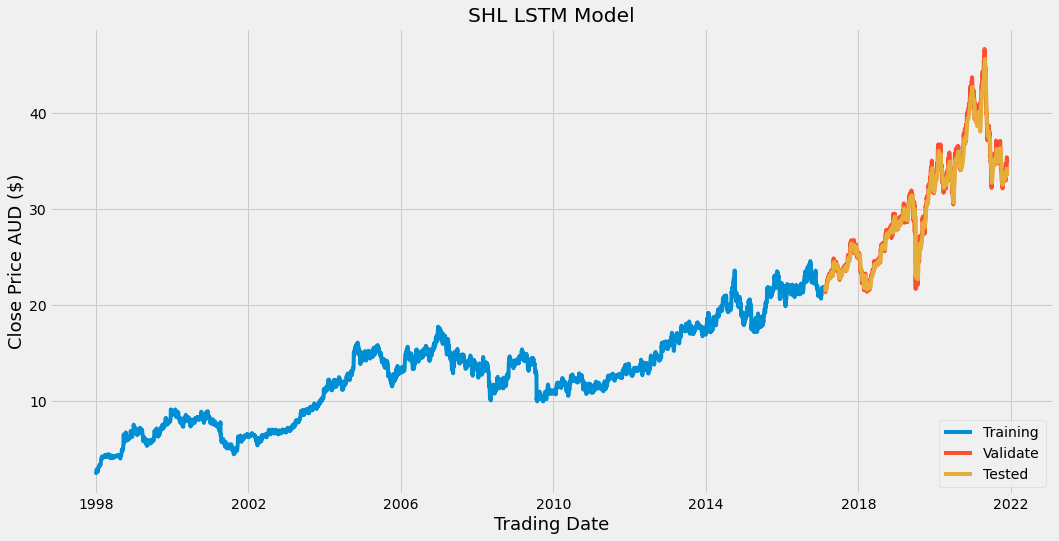

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('SHL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(1998,2025,4)
plt.xticks([0,1000,2000,3000,4000,5000,6000],x)
plt.savefig('../static/data/images/shl_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
4782  21.959999    21.817291    0.142708
4783  21.490000    21.862942   -0.372942
4784  21.340000    21.784184   -0.444184
4785  21.420000    21.644335   -0.224335
4786  21.700001    21.531715    0.168286
...         ...          ...         ...
5972  33.509998    33.867367   -0.357368
5973  34.270000    33.667458    0.602543
5974  35.400002    33.675949    1.724052
5975  35.340000    34.028221    1.311779
5976  34.820000    34.397556    0.422443

[1195 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.shl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

03/08/2022 Last close $34.81999969482422 Predicted next day share price $34


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/shl_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list shl_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/shl_model.sav')

In [32]:
# query the shl collection and load into dataframe

df_mongo = pd.DataFrame(list(db.shl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[34.369999  ],
       [34.900002  ],
       [35.330002  ],
       [35.91      ],
       [35.619999  ],
       [35.799999  ],
       [35.66      ],
       [36.009998  ],
       [36.669998  ],
       [36.16      ],
       [36.27      ],
       [36.110001  ],
       [36.23      ],
       [36.700001  ],
       [36.220001  ],
       [36.439999  ],
       [35.599998  ],
       [35.259998  ],
       [34.619999  ],
       [33.889999  ],
       [34.220001  ],
       [33.990002  ],
       [33.740002  ],
       [32.52      ],
       [32.25      ],
       [32.709999  ],
       [31.959999  ],
       [32.75      ],
       [32.360001  ],
       [32.080002  ],
       [32.48      ],
       [32.900002  ],
       [32.779999  ],
       [32.650002  ],
       [32.610001  ],
       [33.009998  ],
       [32.869999  ],
       [33.259998  ],
       [33.029999  ],
       [33.040001  ],
       [33.119999  ],
       [32.84      ],
       [33.32      ],
       [33.349998  ],
       [33.279999  ],
       [33

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/shl_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_shl(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_shl(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[34.27,
 34.35,
 34.37,
 34.38,
 34.37,
 34.35,
 34.34,
 34.32,
 34.3,
 34.29,
 34.27,
 34.26,
 34.25,
 34.24,
 34.23,
 34.23,
 34.21,
 34.2,
 34.19,
 34.18,
 34.17,
 34.16,
 34.15,
 34.15,
 34.14,
 34.13,
 34.12,
 34.12,
 34.11,
 34.11,
 34.11,
 34.11,
 34.1,
 34.1,
 34.1,
 34.1,
 34.09,
 34.09,
 34.09,
 34.09,
 34.08,
 34.08,
 34.08,
 34.08,
 34.07,
 34.07,
 34.07,
 34.07,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.06,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07,
 34.07

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  04-08-2022   Thursday
1        2  05-08-2022     Friday
2        3  08-08-2022     Monday
3        4  09-08-2022    Tuesday
4        5  10-08-2022  Wednesday
..     ...         ...        ...
203    204  16-05-2023    Tuesday
204    205  17-05-2023  Wednesday
205    206  18-05-2023   Thursday
206    207  19-05-2023     Friday
207    208  22-05-2023     Monday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-03 00:00:00
-7 days, 4:48:59.290753
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [37]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/650594884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


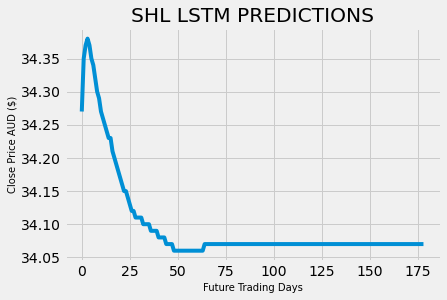

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('SHL LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/shl_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 34.27}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


4782 5977 6153


In [41]:
first_val=df_mongo.iloc[:,1].values
first_date = first_val[0]
print("FIRST DATA VALUE: "+first_date.strip('/02'))

FIRST DATA VALUE: 4/01/1999


C:\Users\antoi\AppData\Local\Temp/ipykernel_1720/3949639338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


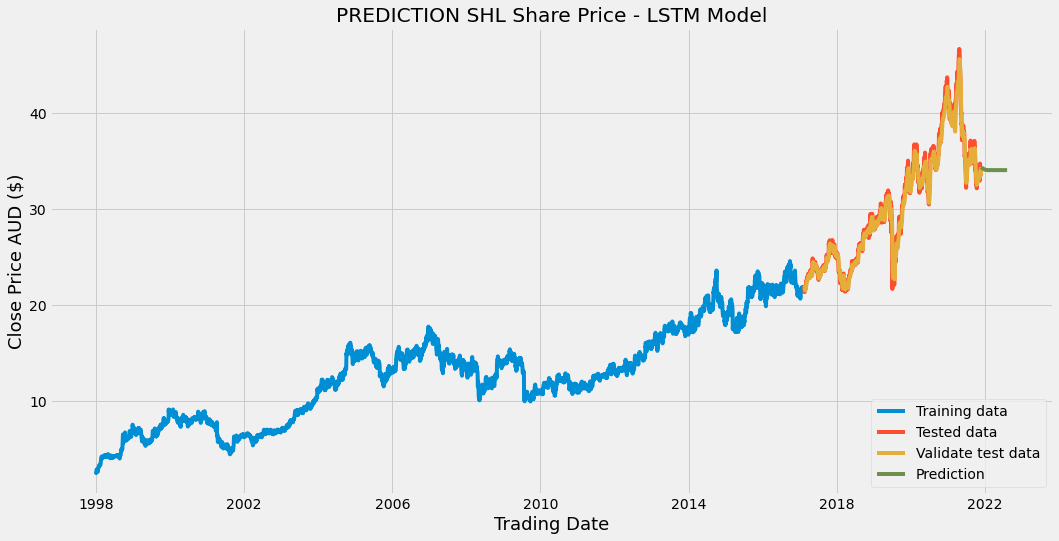

In [42]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION SHL Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(1998,2026,4)
plt.xticks([0,1000,2000,3000,4000,5000,6000],x)
plt.savefig('../static/data/images/shl_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [43]:
# Query all
name = 'SHL'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e630de01fb10179c7be4b4'), 'model': 'LSTM', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 33, 'actual': 34.27, 'difference': -1.27, 'rmse': 0.07788}
{'_id': ObjectId('62ea3af48b4c3f84ed6807a7'), 'model': 'RFR', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 32, 'actual': 34, 'difference': -1.9845, 'accuracy': 96.92}


In [44]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62ea3af48b4c3f84ed6807a7'), 'model': 'RFR', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 32, 'actual': 34, 'difference': -1.9845, 'accuracy': 96.92}


In [45]:
# Set keys and values of company
name = 'SHL'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 03/08/2022,predicted $34, actual $34.82, difference -0.8200000000000003, rmse 0.2318


In [46]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62ea3af48b4c3f84ed6807a7'), 'model': 'RFR', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 32, 'actual': 34, 'difference': -1.9845, 'accuracy': 96.92}
{'_id': ObjectId('62ea3ba5b3a478d58fd7aceb'), 'model': 'LSTM', 'name': 'SHL', 'date': '03/08/2022', 'predicted': 34, 'actual': 34.82, 'difference': -0.82, 'rmse': 0.2318}


In [47]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07/2022', 'predicted': 0.92, 'actual': 1.09, 'differece': -0.170910457265107, 'accuracy': 91.93}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022